# Using BERT as the base model for NLP classification (transfer learning)

### NOTE! You'll need GPU for this notebook, even the smallest version of the BERT-model is rather heavy to train!

# For my own dataset but its very similar dataset that we experinced in class

In [105]:
# Converting Xlsx file into CVC file
# I download this file from this url https://data.mendeley.com/datasets/pk5vs5wjxm/1?utm_source=chatgpt.com


# Load the Excel file
#xlsx_file = "NewsRecommendationDataset.xlsx"
# Convert the first sheet to CSV
# df = pd.read_excel(xlsx_file, sheet_name=0)
# df.to_csv("News_Recommended.csv", index=False)

In [ ]:
# I did experiments by changing the parameters for example Epochs etc but I got best results are as follows
# These two plots show the training and validation performance of a model over 30 epochs:
# Train Loss and Validation Loss both decrease steadily, showing that the model is learning and generalizing.
# There's a small gap between them, indicating minimal overfitting.
# The loss decreases consistently, suggesting stable training.

# Training Accuracy rises quickly and approaches 1.0 (near perfect).
# Validation Accuracy also increases and plateaus around 0.95, showing the model is performing well on unseen data.
# The close alignment of both lines suggests the model is not overfitting and generalizes well.
# Overall, This is a well-trained model with good generalization and no major signs of overfitting.

In [ ]:
# Economy
# Precision: 0.87 → Some false positives. Recall: 0.96 → Most actual Economy articles were correctly identified. and
#F1-score: 0.92 → Strong overall performance, slightly lower precision.

# Environment
# Precision: 0.97 → Very few false positives. Recall: 1.00 → All Environment articles were correctly classified.
# F1-score: 0.99 → Excellent classification.

# Politics
# Precision: 1.00 → No false positives at all. Recall: 0.89 → A few Politics articles were misclassified.
# F1-score: 0.94 → High overall performance, recall could be improved.

# Overall Performance
# Accuracy: 0.95 → 95% of total predictions were correct.
#  Macro & Weighted Averages: All metrics are at 0.95 → Balanced performance across all classes, even with class size differences.

In [ ]:
# Confusion Matrix
# The classifier performs very well overall. It does best on Politics and Economy.
# The main confusion is misclassifying Economy as Environment (4 times).
# Environment: Precision 87.1%, Recall 96.4%, F1 Score 91.5%
# Politics: Precision 97.1%, Recall 100%, F1 Score 98.5%
# Economy: Precision 100%, Recall 89.5%, F1 Score 94.4%

# Overall my thoughts on comparisons with BERT TORCH or ML / Naive-Bayes

In [ ]:
# Here’s a brief comparison summary between Naive Bayes (ML) and BERT (Torch):

# Overall Accuracy: BERT performs slightly better (95%) than Naive Bayes (93%), showing improved generalization and understanding.
# Class-wise Performance: BERT has higher precision and recall in critical classes like Politics and Economy, especially in precision for Politics (1.00 vs. 0.97).
# Macro/Weighted Averages: BERT consistently outperforms Naive Bayes across all averaged metrics (0.95 vs. 0.93), reflecting better balance and robustness.

In [106]:
# first step: Connect your Google Drive into this notebook
# tip: use the file explorer on the left, and click the Google Drive-icon to connect
data_file_path = "News_Recommended.csv"

In [107]:
# load the data to test if it works at all
import pandas as pd
df = pd.read_csv(data_file_path)

In [108]:
# quick check, does the data load?
df.head(3)

,headlines,newspaper,description,catagories,link
0,MV Abdullah leaves UAE for last leg of homewar...,The Daily Star,"The ship MV Abdullah, with 23 Bangladeshi crew...",Business,https://www.thedailystar.net/Health
1,"Heatwave: After fiery April, milder May beckons",The Daily Star,Relief from a severe heatwave expected in May ...,Weather,https://www.thedailystar.net/Health
2,Bar pharmas from raising medicine prices at will,The Daily Star,High Court orders measures to prevent pharmace...,Healthcare,https://www.thedailystar.net/Health


## Step 1.5 - Do the same preprocessing as in the Naive-Bayes -example

In [109]:
# combine headline with short_description (to have a bit more data)
df['headlines'] = df['headlines'] + " - " + df['description']

In [110]:
# select only "category" and "headline" columns
# category is going to be the target
df = df[['catagories', 'headlines']]

In [111]:
# DOUBLE-CHECK THE ORDER AFTER TARGET VARIABLE HAS BEEN ENCODED TO INTEGERS
TEXT_LABELS = ['Environment', 'Politics', 'Economy']

In [112]:
# List of categories to filter
categories_to_filter = TEXT_LABELS

# Filter rows where category is in the list
df = df[df['catagories'].isin(categories_to_filter)]

In [113]:
# final check, is the data otherwise good to go?
df.head()

,catagories,headlines
3,Economy,IMF Loan: Govt may miss two key targets set fo...
7,Economy,Will BSEC ever learn from its missteps? - Anal...
12,Economy,How do we protect the worst victims of inflati...
13,Economy,Familiar risks haunt Chattogram markets - Iden...
16,Economy,IMF suggestions for Bangladesh - IMF provides ...


In [114]:
# this phase usually takes time, since its made by CPU
# might be a better idea to save the processed version to another csv-file
# import nltk for stopword removal
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import multiprocessing as mp

# remove stopwords
nltk.download('stopwords')

# define a function which we can apply to our data
# => remove English stopwords (filler words)
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stopwords.words('english')]
    return ' '.join(words)

# apply the function to the 'headline' column
df['headlines'] = df['headlines'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/waseemimran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
df.head()

,catagories,headlines
3,Economy,IMF Loan: Govt may miss two key targets set fo...
7,Economy,BSEC ever learn missteps? - Analysts question ...
12,Economy,protect worst victims inflation? - Raises ques...
13,Economy,Familiar risks haunt Chattogram markets - Iden...
16,Economy,IMF suggestions Bangladesh - IMF provides reco...


## Step 2: All needed Torch and BERT -imports

In [116]:
# import Torch + neural network features
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# import HuggingFace transformers, BERT imports
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput

# rest of the needed imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# import matplotlib for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# enable Torch to use GPU if its available, default back to CPU if not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check which device is used
print(f"Using device: {device}")

# Remember: you want to use cuda (GPU) for this
# if you run out of free GPU credits, you can try CPU but with a very small dataset
# = less than 2000 rows TOTAL for training

Using device: cpu


## Step 3: Define the dataset wrapper + training -function for Torch

In [117]:
# Dataset class for text data, to be used by Torch training code
# we need this data wrapper in order to finetune the BERT Model
class TextDataset(Dataset):
    # initialize the dataset: texts = training data, labels = target values
    # which tokenizer to use for this data and what is the maximum length of a single
    # piece of data (512)
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [118]:
# model training function for Torch
def train_model(model, train_dataloader, val_dataloader, epochs=3, lr=2e-5):
    # make this model use the current device (GPU or CPU)
    model.to(device)

    # as per common with NLP tasks => optimizer is AdamW
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # our loss function is Cross Entropy
    loss_fn = nn.CrossEntropyLoss()

    # Training progress trackers for training metrics later!
    # note: this is built-in in Keras, but not in Torch and TensorFlow Core
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # traing for as many epochs as defined
    for epoch in range(epochs):
        # initialize variables for this epoch
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        # EPOCH TRAINING - PHASE 1: train the model
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        # keep track of current accuracy and loss for TRAINING DATA
        history['train_acc'].append(correct / total)
        history['train_loss'].append(total_loss / len(train_dataloader))
        print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_dataloader)}, Train Accuracy = {correct / total}")

        # EPOCH VALIDATION - PHASE 2: validate this epoch
        model.eval()
        correct, total, total_val_loss = 0, 0, 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                total_val_loss += loss.item()
                correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

        # keep track of current accuracy and loss for VALIDATION DATA
        history['val_acc'].append(correct / total)
        history['val_loss'].append(total_val_loss / len(val_dataloader))

        # this epoch's done, print the the current progress into notebook
        print(f"Validation Loss = {total_val_loss / len(val_dataloader)}, Validation Accuracy = {correct / total}")
        print("------------------------------------------")

    return history

## Step 4: Finalized and split the data and train the model

In [119]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df['category_encoded'] = label_encoder.fit_transform(df['catagories'])

In [120]:
df.head()

,catagories,headlines,category_encoded
3,Economy,IMF Loan: Govt may miss two key targets set fo...,0
7,Economy,BSEC ever learn missteps? - Analysts question ...,0
12,Economy,protect worst victims inflation? - Raises ques...,0
13,Economy,Familiar risks haunt Chattogram markets - Iden...,0
16,Economy,IMF suggestions Bangladesh - IMF provides reco...,0


In [121]:
# prompt: show all possible combinations of category and category_encoded in df

for category, encoded in zip(df['catagories'].unique(), df['category_encoded'].unique()):
  print(f"Category: {category}, Encoded: {encoded}")


Category: Economy, Encoded: 0
Category: Politics, Encoded: 2
Category: Environment, Encoded: 1


In [122]:
# based on the result above, this is the order of labels
# correct the labels here if needed
TEXT_LABELS = ['Environment', 'Politics', 'Economy']

In [123]:
# X/y split!
X = df['headlines']
y = df['category_encoded']

In [124]:
# next step, download the BERT model and the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('google/bert_uncased_L-2_H-128_A-2', num_labels=len(TEXT_LABELS))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [125]:
# because of Torch datasets, the train/test -split is slightly different
train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# convert series to lists
train_texts = train_texts.tolist()
val_texts = val_texts.tolist()
train_labels = train_labels.tolist()
val_labels = val_labels.tolist()

# Create datasets and dataloaders
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# as in Image AIs => shuffle the training data, but don't shuffle the validation data
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [126]:
# train the model
history = train_model(model, train_dataloader, val_dataloader, epochs=30)

Epoch 1: Train Loss = 1.0783211719989776, Train Accuracy = 0.42385786802030456
Validation Loss = 1.0793008391673748, Validation Accuracy = 0.3434343434343434
------------------------------------------
Epoch 2: Train Loss = 1.023821041584015, Train Accuracy = 0.467005076142132
Validation Loss = 1.0315676148121173, Validation Accuracy = 0.36363636363636365
------------------------------------------
Epoch 3: Train Loss = 0.962317361831665, Train Accuracy = 0.5761421319796954
Validation Loss = 0.961495422399961, Validation Accuracy = 0.5959595959595959
------------------------------------------
Epoch 4: Train Loss = 0.883890221118927, Train Accuracy = 0.7284263959390863
Validation Loss = 0.8855187663665185, Validation Accuracy = 0.7575757575757576
------------------------------------------
Epoch 5: Train Loss = 0.8184078538417816, Train Accuracy = 0.7969543147208121
Validation Loss = 0.8127952172205999, Validation Accuracy = 0.7676767676767676
------------------------------------------
Epo

## Training and error metrics!

<Axes: >

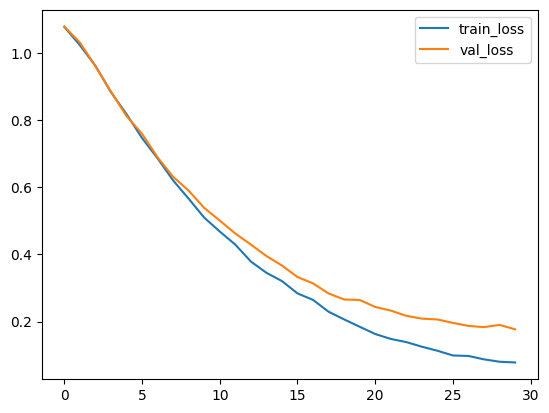

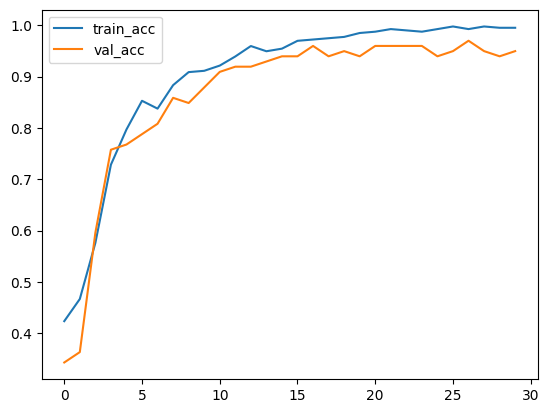

In [127]:
loss_df = pd.DataFrame(history)
loss_df[['train_loss', 'val_loss']].plot()
loss_df[['train_acc', 'val_acc']].plot()

In [128]:
# we need to process the data in batches in Torch in order to
# the true values and the matching predictions

model.eval()
y_true = []
y_pred = []

# process through testing dataset and collect true and prediction values for metrics
with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.logits.argmax(dim=1).cpu().numpy())

# classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.97      1.00      0.99        33
           2       1.00      0.89      0.94        38

    accuracy                           0.95        99
   macro avg       0.95      0.95      0.95        99
weighted avg       0.95      0.95      0.95        99



<Axes: >

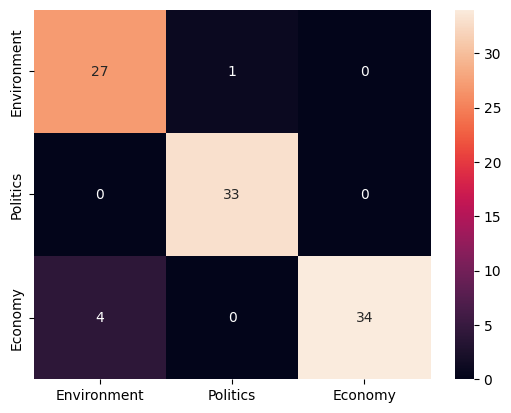

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g',
            xticklabels=TEXT_LABELS, yticklabels=TEXT_LABELS)


In [130]:
 # get one-hot representation of y_true and y_pred 
y_true_onehot = pd.get_dummies(y_true).values
y_pred_onehot = pd.get_dummies(y_pred).values

print(f"ROC AUC: {roc_auc_score(y_true_onehot, y_pred_onehot, multi_class='ovr')}")

ROC AUC: 0.9645888355117412


In [131]:
# test the model
model.eval()

# our example news headline
sample = "Leaders gather for an Economy Technology  to address the challenges of climate change, discussing strategies for mitigation, adaptation, and global cooperation."
sample = "Timothee Chalamet and Demi Moore among winners at SAG Awards - a major Oscars predictor"

# process the text so it can be put through the model
encoding = tokenizer(sample, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
outputs = model(input_ids, attention_mask=attention_mask)
label = outputs.logits.argmax(dim=1).item()

# logits don't work similarly as probabilities (0-100%)
# it's more like => whatever is the biggest value => prediction
# similar values might imply problems though
# basically this is the format without softmax

print(f"Sample text: {sample}")
print(f"Predicted sentiment: {TEXT_LABELS[label]}")

# convert the raw logits into probabilities / softmax
probs = torch.nn.functional.softmax(outputs.logits, dim=1)

# convert the scientific format into decimal format
formatted_probs = [f"{p:.6f}" for p in probs.cpu().squeeze().tolist()]

# Print formatted probabilities
print()
print("Predictions for each label:\n")
print(TEXT_LABELS)
print(formatted_probs)

Sample text: Timothee Chalamet and Demi Moore among winners at SAG Awards - a major Oscars predictor
Predicted sentiment: Economy

Predictions for each label:

['Environment', 'Politics', 'Economy']
['0.064516', '0.016860', '0.918623']
